In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import mytools
import mymodels
from matplotlib import colors
import scipy as sp
from scipy.special import iv
from scipy.optimize import curve_fit



In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Load Heteroscedastic model
model_HSCDC = torch.load('../3D_Heteroscedastic_Convnet_models/3D_HSCDC.pt').to(device)


Using cuda device


In [3]:
# Function to get prediction for a given test case
def get_pred(Energy=50,Diff='H'):
    
    # Read pandas dataframe with all information about sparse testing tensors
    st_info = pd.read_pickle('/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/sparse_tensor_info.pk')

    # Make custom dataset
    MyDataset = mytools.CustomDataset(dir_loc='/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/', st_info=st_info)

    # Create DataLoader
    batch_size = 64
    test_dataloader = DataLoader(MyDataset, batch_size=batch_size, shuffle=True)

    # Print tensor shapes
    for X_plot, y_plot, offset_plot in test_dataloader:
        print(f"Shape of X [N, C, H, W, D]: {X_plot.shape}")
        print(f"Shape of y: {y_plot.shape} {y_plot.dtype}")
        print("Offsets: ", offset_plot.shape)
        break

    #Record shape of voxel grid
    grid_shape = X_plot.shape[1:4]
    print("Voxel grid shape: " , grid_shape)
    
    # Obtain predictions and Labels
    v_pred_HSCDC, K_pred_HSCDC, v_true_HSCDC, off_true_HSCDC = mytools.test_HSCDC(test_dataloader,model_HSCDC,device)
    
    return  v_pred_HSCDC, K_pred_HSCDC, v_true_HSCDC, off_true_HSCDC
    

In [4]:
# Get predictions for different test cases
v_pred_HSCDC_50keV_H, K_pred_HSCDC_50keV_H, v_true_HSCDC_50keV_H, off_true_HSCDC_50keV_H = get_pred(Energy=50,Diff='H')
v_pred_HSCDC_50keV_L, K_pred_HSCDC_50keV_L, v_true_HSCDC_50keV_L, off_true_HSCDC_50keV_L = get_pred(Energy=50,Diff='L')
v_pred_HSCDC_40keV_H, K_pred_HSCDC_40keV_H, v_true_HSCDC_40keV_H, off_true_HSCDC_40keV_H = get_pred(Energy=40,Diff='H')
v_pred_HSCDC_40keV_L, K_pred_HSCDC_40keV_L, v_true_HSCDC_40keV_L, off_true_HSCDC_40keV_L = get_pred(Energy=40,Diff='L')


Shape of X [N, C, H, W, D]: torch.Size([64, 120, 120, 120, 1])
Shape of y: torch.Size([64, 3]) torch.float32
Offsets:  torch.Size([64, 3])
Voxel grid shape:  torch.Size([120, 120, 120])
Shape of X [N, C, H, W, D]: torch.Size([64, 120, 120, 120, 1])
Shape of y: torch.Size([64, 3]) torch.float32
Offsets:  torch.Size([64, 3])
Voxel grid shape:  torch.Size([120, 120, 120])
Shape of X [N, C, H, W, D]: torch.Size([64, 120, 120, 120, 1])
Shape of y: torch.Size([64, 3]) torch.float32
Offsets:  torch.Size([64, 3])
Voxel grid shape:  torch.Size([120, 120, 120])
Shape of X [N, C, H, W, D]: torch.Size([64, 120, 120, 120, 1])
Shape of y: torch.Size([64, 3]) torch.float32
Offsets:  torch.Size([64, 3])
Voxel grid shape:  torch.Size([120, 120, 120])


# Test Kappa for a all test cases

In [5]:
x_50H = K_pred_HSCDC_50keV_H.flatten().numpy()
y_50H = torch.arccos(mytools.CS(v_pred_HSCDC_50keV_H,v_true_HSCDC_50keV_H)).numpy()

x_50L = K_pred_HSCDC_50keV_L.flatten().numpy()
y_50L = torch.arccos(mytools.CS(v_pred_HSCDC_50keV_L,v_true_HSCDC_50keV_L)).numpy()

x_40H = K_pred_HSCDC_40keV_H.flatten().numpy()
y_40H = torch.arccos(mytools.CS(v_pred_HSCDC_40keV_H,v_true_HSCDC_40keV_H)).numpy()

x_40L = K_pred_HSCDC_40keV_L.flatten().numpy()
y_40L = torch.arccos(mytools.CS(v_pred_HSCDC_40keV_L,v_true_HSCDC_40keV_L)).numpy()

xs = np.concatenate((x_50H,x_50L,x_40H,x_40L))
ys = np.concatenate((y_50H,y_50L,y_40H,y_40L))

array([[ 1.        , -0.28953457],
       [-0.28953457,  1.        ]])

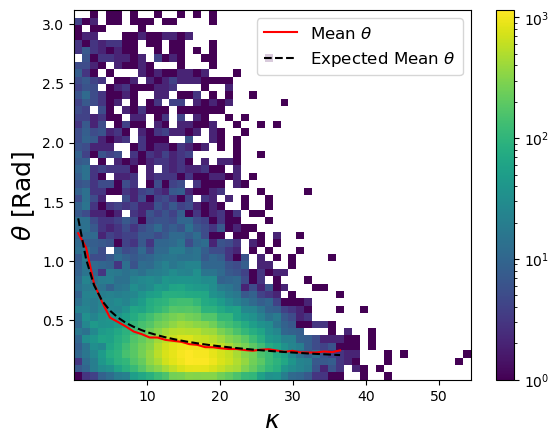

In [6]:
h, x_edges, y_edges, image = plt.hist2d(xs, ys, bins=(50, 50), norm = colors.LogNorm())

y_centers = (y_edges[:-1]+y_edges[1:])/2.0
x_centers = (x_edges[:-1]+x_edges[1:])/2.0

mean_vals = []
mean_centers = []
for i,center in enumerate(x_centers):
    if np.sum(h[i,:]) > 10:
        mean_vals += [np.dot(h[i,:],y_centers)/np.sum(h[i,:])]
        mean_centers += [center]
    
Kappas = np.array(mean_centers)
exp_mean = (iv(0,Kappas)-np.exp(-Kappas))*np.pi/(2*np.sinh(Kappas))

plt.plot(Kappas,mean_vals,color='r',label=r"Mean $\theta$")
plt.plot(Kappas,exp_mean ,color='k',ls='--',label=r"Expected Mean $\theta$")
plt.legend( fontsize=12)
plt.xlabel(r"$\kappa$", fontsize=18)
plt.ylabel(r"$\theta$ [Rad]", fontsize=18)
plt.colorbar()
plt.savefig("kappa1.pdf")

# Print correleation coefficient matrix
np.corrcoef(np.asarray([xs,ys]))


In [7]:
# Prob density fit Function :
def prob_den(x,kappa):
    return ( kappa / ( 2 * np.sinh(kappa) ) ) * np.exp( kappa * x )


kappa fit:  20.871682262656567 +/- 0.511538218244947
center value:  22.282483633717057 +/- 0.5434483421663749


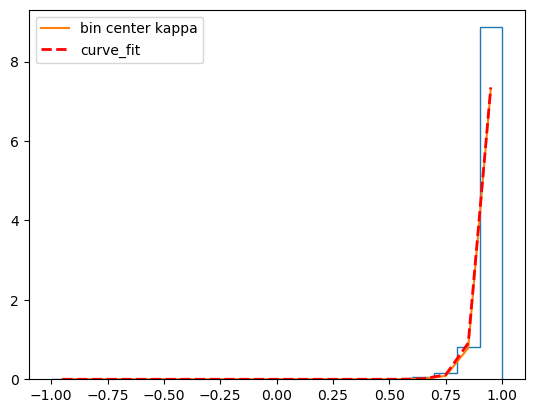

In [8]:
i = 20

# Specify the edges of the kappa bin that we are isolating
L_edge = x_edges[i]
R_edge = x_edges[i+1]
# Get the Angle values for events contained in the specified bin
ys_cut = ys[(xs>L_edge)&(xs<R_edge)]
# Convert angles to cos(angles)
cos_thetas = np.cos(ys_cut)

# Bin the cos(angles)
bins= np.arange(-1,1.1,0.1)
centers = (bins[:-1]+bins[1:])/2.0
diff = (max(bins)-min(bins))/len(centers)

hist, bin_edges, patches = plt.hist(cos_thetas, bins=bins, histtype='step',density=True)

# hist = hist[:-1]
# centers = centers[:-1]


# Find Non-zero bins in Histogram
nz = hist>0
# compute count instead of prob. density
counts = hist[nz]*diff*len(ys_cut)
# Use count to get fractional uncertainty
frac_err = (np.sqrt(counts)/counts)
# Use fractional uncertainty to get uncertainty 
n_err = hist[nz]*frac_err


# Plot the probability distribution using the bin center value of kappa 
plt.plot(centers,prob_den(centers,x_centers[i]),label="bin center kappa")

# Use Scipy to fit the probability density to the histogram
coeff, covar = curve_fit(prob_den, centers[nz], hist[nz], sigma=n_err, absolute_sigma=True,p0=(x_centers[i]))

# Plot the fit probability density
plt.plot(centers, prob_den(centers,*coeff), 'r--', linewidth=2, label='curve_fit')


# Print scipy fit parameters:
perr = np.sqrt(np.diag(covar))
print("kappa fit: ", coeff[0], "+/-", perr[0] )
print("center value: ", x_centers[i], "+/-", (R_edge-L_edge)/2 )


plt.legend()


In [9]:
k_fits = []
k_fits_errs = []
k_centers = []
k_centers_errs = [] 

for i,center in enumerate(x_centers):

    # Specify the edges of the kappa bin that we are isolating
    L_edge = x_edges[i]
    R_edge = x_edges[i+1]
    # Get the Angle values for events contained in the specified bin
    ys_cut = ys[(xs>L_edge)&(xs<R_edge)]
    
    if len(ys_cut) > 10:
    
        # Convert angles to cos(angles)
        cos_thetas = np.cos(ys_cut)

        # Bin the cos(angles)
        bins= np.arange(-1,1.1,0.1)
        centers = (bins[:-1]+bins[1:])/2.0
        diff = (max(bins)-min(bins))/len(centers)

        hist, bin_edges = np.histogram(cos_thetas, bins=bins, density=True)

        # Find Non-zero bins in Histogram
        nz = hist>0
        # compute count instead of prob. density
        counts = hist[nz]*diff*len(ys_cut)
        # Use count to get fractional uncertainty
        frac_err = (np.sqrt(counts)/counts)
        # Use fractional uncertainty to get uncertainty 
        n_err = hist[nz]*frac_err

        # Use Scipy to fit the probability density to the histogram
        coeff, covar = curve_fit(prob_den, centers[nz], hist[nz], sigma=n_err, absolute_sigma=True,p0=(center))

        # Print scipy fit parameters:
        perr = np.sqrt(np.diag(covar))
        print(i)
        print("kappa fit: ", coeff[0], "+/-", perr[0] )
        print("center value: ", center, "+/-", (R_edge-L_edge)/2 )
        print("-----------------------------------------------")

        k_fits += [coeff[0]]
        k_fits_errs += [ perr[0]]
        k_centers += [center]
        k_centers_errs += [(R_edge-L_edge)/2 ] 



0
kappa fit:  0.878400208003702 +/- 0.10365875270559664
center value:  0.5445499470620416 +/- 0.5434483421663754
-----------------------------------------------
1
kappa fit:  1.4077679355649553 +/- 0.09618074230309066
center value:  1.6314466313947924 +/- 0.5434483421663754
-----------------------------------------------
2
kappa fit:  4.920572393301671 +/- 0.25337508900332684
center value:  2.718343315727543 +/- 0.5434483421663754
-----------------------------------------------
3
kappa fit:  7.439970439304301 +/- 0.36111157136732935
center value:  3.805240000060294 +/- 0.5434483421663754
-----------------------------------------------
4
kappa fit:  9.396649224329705 +/- 0.45487322150047643
center value:  4.892136684393044 +/- 0.5434483421663754
-----------------------------------------------
5
kappa fit:  11.988751872841979 +/- 0.5371885862357936
center value:  5.979033368725796 +/- 0.5434483421663754
-----------------------------------------------
6
kappa fit:  13.243198044264975 +/- 

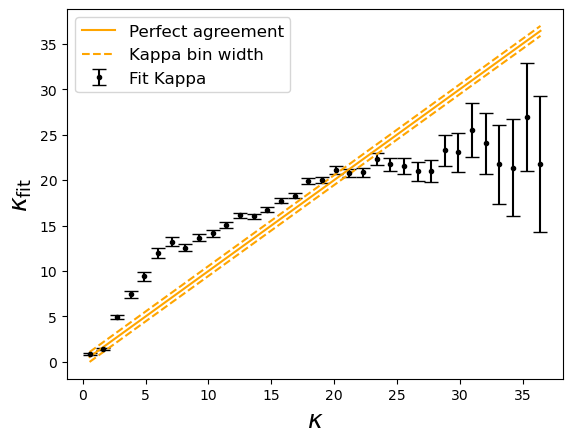

In [10]:
k_fits = np.array(k_fits)
k_fits_errs = np.array(k_fits_errs)
k_centers = np.array(k_centers)
k_centers_errs = np.array(k_centers_errs)

plt.errorbar(k_centers[0:60], k_fits[0:60], yerr = k_fits_errs[0:60], xerr = None, ls='none',color='k',fmt='.',capsize=5,label="Fit Kappa") 
plt.plot(k_centers,k_centers,color ='orange',label="Perfect agreement")
plt.plot(k_centers,k_centers+k_centers_errs, ls = '--',color ='orange', label="Kappa bin width")
plt.plot(k_centers,k_centers-k_centers_errs,ls = '--',color ='orange')
plt.xlabel(r"$\kappa$", fontsize=18)
plt.ylabel(r"$\kappa_{\rm{fit}}$", fontsize=18)
plt.legend( fontsize=12)
plt.savefig("kappa2.pdf")
